In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

# Urbanisation

** ADD description

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [3]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr


In [4]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [86]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
platform_analysis = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2013-1-1'
baseline_end_date = '2014-12-1'

#set the analysis start and end of period
#analysis_start_date = '2017-1-1'
#analysis_end_date = '2017-12-1'

# If a geomedian is selected, it will take much longer to process

# options are "median" or "geomedian"
#mosaic_type = "geomedian" # change this to geomedian 

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#ai_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((179.4389622562436 -16.668794626017938,179.51758316688813 -16.668794626017938,179.51758316688813 -16.734562495004166,179.4389622562436 -16.734562495004166,179.4389622562436 -16.668794626017938))"
#aoi_wkt = "POLYGON((179.34386185341157 -16.511847130448928,179.73662308388032 -16.511847130448928,179.73662308388032 -16.83810084556268,179.34386185341157 -16.83810084556268,179.34386185341157 -16.511847130448928))"
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

## create AOI

In [87]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [88]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [89]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [90]:
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [91]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [92]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [93]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [94]:
print(lat_range)

(3868865.296636806, 3882539.0512192366)


In [95]:
print(lon_range)

(1962643.4711290102, 1978898.4636792026)


## Translate inputs and load data

In [96]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_geomedian_annual'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product

In [97]:
#baseline_product, baseline_measurement = create_product_measurement(platform_base)
#analysis_product, analysis_measurement = create_product_measurement(platform_analysis)

In [98]:
baseline_product = create_product_measurement(platform_base)
analysis_product = create_product_measurement(platform_analysis)

In [99]:
#create resolution
resolution = (-res, res)

In [100]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [101]:
x_extents = (2050000.0, 2150000.0)
y_extents = (3999700.0, 4100300.0)

In [102]:
#lon_range = (2063266.0, 2105301.0)
#lat_range = (4017815.0, 4053752.0)

In [103]:
#lon_range = (2050000.0, 2150000.0)
#lat_range = (3999700.0, 4100300.0)

In [104]:
x_extents = (2033081.0, 2133081.0)
y_extents = (3999700.0, 4100300.0)

In [105]:
#x_extents = (2115000.0, 2160000.0)
#y_extents = (3995000.0, 4040000.0)

In [106]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

NameError: name 'analysis_start_date' is not defined

In [107]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    #'y': y_extents,
    #'x': x_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [108]:
baseline_ds = dc.load(
    #time = 2017,
    time = baseline_time_period,
    #measurements = baseline_measurement,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [109]:
analysis_ds = dc.load(
    time = analysis_time_period,
    measurements = analysis_measurement,
    product = analysis_product,
    platform = platform_analysis,
    crs = crs,
    **query
)

NameError: name 'analysis_time_period' is not defined

> #### Check if loads are valid

In [110]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [111]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [112]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 2, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2014-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    green    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [113]:
#baseline_ds.red.plot(col='time', cmap='Greens', col_wrap=3)


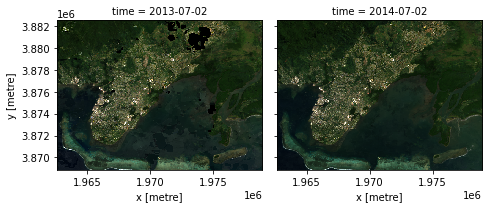

In [114]:
baseline_ds[['red','green','blue']].to_array().plot.imshow(
    x=baseline_ds.crs.dimensions[1],
    y=baseline_ds.crs.dimensions[0],
    col='time',
    #figsize=(20, 20),
    vmin=0,
    vmax=3000,
    col_wrap=4,
    #add_colorbar=False
)

In [115]:
baseline_ds_2 = baseline_ds.compute()

In [116]:
print(baseline_ds_2)

<xarray.Dataset>
Dimensions:  (time: 2, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2014-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 103 -1 116 124 96 121 ... 433 433 437 425 429
    green    (time, y, x) int16 385 270 372 375 363 431 ... 491 498 506 501 503
    red      (time, y, x) int16 185 115 206 210 174 227 ... 237 238 242 238 240
    nir      (time, y, x) int16 3727 3208 3288 3128 3377 ... 128 130 133 126 128
    swir1    (time, y, x) int16 1405 1209 1322 1288 1229 ... 137 144 146 143 145
    swir2    (time, y, x) int16 499 464 521 510 441 523 ... 118 123 125 122 122
Attributes:
    crs:      EPSG:3460


## Calculate NDBI

In [117]:
from datacube_utilities.createindices import NDVI, NDWI, NDBI

In [118]:
ndbi_base = NDBI(baseline_ds_2)  # Urbanization

In [119]:
ndbi_ds = xr.DataArray.to_dataset(ndbi_base, dim = 'time')

In [120]:
test = ndbi_ds

In [121]:
print(ndbi_ds)

<xarray.Dataset>
Dimensions:              (x: 543, y: 456)
Coordinates:
  * y                    (y) float64 3.883e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x                    (x) float64 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    2013-07-02 00:00:00  (y, x) float64 -0.7638 -0.7473 ... -0.06329 -0.06173
    2014-07-02 00:00:00  (y, x) float64 -0.781 -0.7717 ... -0.01613 -0.024


In [133]:
write_geotiff_from_xr('test.tiff', ndbi_ds, crs=output_projection, x_coord = 'x', y_coord = 'y')

ValueError: supplied range of [-65.0, inf] is not finite

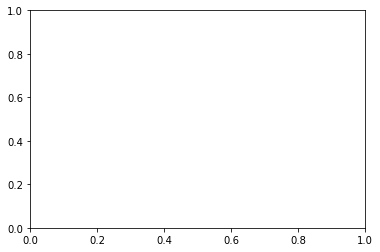

In [134]:
(ndbi_base).plot(cmap = "Reds", vmin = -1, vmax = 0)
#ndbi_base.plot(col='time', cmap='Reds', col_wrap=3, vmin = -1, vmax = 0)

In [ ]:
import geopandas
shpFile = geopandas.read_file("urbanisation/Urban_suva.shp", driver='shapefile')

In [135]:
rasterTiff = 'test.tiff'

In [136]:
print(shpFile)

   id                                           geometry
0   1  POLYGON ((1975434.206 3880672.745, 1974116.203...


In [137]:
from rasterstats import zonal_stats

In [138]:
createData = zonal_stats(shpFile, rasterTiff, stats= 'mean', geojson_out=True)

In [160]:
import rasterio
with rasterio.open('test.tiff') as src:
    affine = src.transform
    array = src.read(2)
zs = zonal_stats(shpFile, array, stats='mean', affine=affine)

In [161]:
print(zs)

[{'mean': -0.47428279630911224}]


In [166]:
import rasterio
with rasterio.open('test.tiff') as src2:
    affine2 = src2.transform
    array2 = src2.read(2)
zs2 = zonal_stats(shpFile, array, stats='mean', affine=affine)

In [164]:
print(zs2)

[{'mean': -0.47428279630911224}]


In [139]:
print(createData)

[{'id': '0', 'type': 'Feature', 'properties': {'id': 1, 'mean': -0.43936056849946636}, 'geometry': {'type': 'Polygon', 'coordinates': (((1975434.205559892, 3880672.745187387), (1974116.203117608, 3881913.227038306), (1974116.203117608, 3881913.227038306), (1973206.8221390198, 3882789.8591889227), (1972963.9156963876, 3883708.832209846), (1973130.035027881, 3884098.329951805), (1974512.3707057647, 3884804.1941709653), (1976932.8068921263, 3881560.652509155), (1975434.205559892, 3880672.745187387)),)}, 'bbox': (1972963.9156963876, 3880672.745187387, 1976932.8068921263, 3884804.1941709653)}]


In [142]:
from geopandas import GeoDataFrame
dataGDF = shpFile
zonalGDF2 = GeoDataFrame.from_features(createData)
#append zonal statistics to the shapefile geodataframe
dataGDF = zonalGDF2.append(dataGDF,sort=False)

In [145]:
print(zonalGDF2)

                                            geometry  id      mean
0  POLYGON ((1975434.206 3880672.745, 1974116.203...   1 -0.439361


In [140]:
from osgeo import gdal
import sys

src_ds = gdal.Open( "INPUT.tif" )
if src_ds is None:
    print 'Unable to open INPUT.tif'
    sys.exit(1)

print "[ RASTER BAND COUNT ]: ", src_ds.RasterCount
for band in range( src_ds.RasterCount ):
    band += 1
    print "[ GETTING BAND ]: ", band
    srcband = src_ds.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print "[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                stats[0], stats[1], stats[2], stats[3] )

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Unable to open INPUT.tif')? (<ipython-input-140-d73effc11ed7>, line 6)

In [63]:
df = ndbi_ds.to_dataframe()

In [64]:
print(df)

                     2013-07-02
x         y                    
1962645.0 3882525.0   -0.763843
          3882495.0   -0.772177
          3882465.0   -0.763733
          3882435.0   -0.746733
          3882405.0   -0.748027
...                         ...
1978905.0 3868995.0   -0.057692
          3868965.0   -0.037736
          3868935.0   -0.098901
          3868905.0   -0.118280
          3868875.0   -0.061728

[247608 rows x 1 columns]


In [171]:
for col in df.columns: 
    print(col) 

ndbi


ValueError: x and y arrays must be equal length.

In [178]:
output = xr.DataArray.to_array(ndbi_base, name = 'ndbi')

AttributeError: type object 'DataArray' has no attribute 'to_array'

In [163]:
print(output)

<xarray.Dataset>
Dimensions:  (time: 1, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    ndbi     (time, y, x) float64 -0.7638 -0.7473 -0.7264 ... -0.06329 -0.06173


In [177]:
write_geotiff_from_xr('param_thres.tiff', output, crs=output_projection, x_coord = 'x', y_coord = 'y')

ValueError: Source shape (1, 1, 456, 543) is inconsistent with given indexes 1

In [166]:
#df_zonal_stats = zonal_stats(shpFile, df, stat = "mean")
createData = zonal_stats(shpFile, ndbi_base, stats= 'mean std count min', affine='affine', geojson_out=True)
    #zonal_stats("polygons.shp", "elevation.tif",
     #       stats="count min mean max median")

TypeError: invalid path or file: <xarray.DataArray (time: 1, y: 456, x: 543)>
array([[[-0.76384288, -0.74727669, -0.72643739, ..., -0.46133333,
         -0.41036977, -0.28922306],
        [-0.77217692, -0.76021532, -0.74324324, ..., -0.5073804 ,
         -0.41579623, -0.4206278 ],
        [-0.76373333, -0.77323062, -0.76626757, ..., -0.52043693,
         -0.51449028, -0.5112485 ],
        ...,
        [-0.11666667, -0.09243697, -0.11173184, ..., -0.06024096,
         -0.04761905, -0.0989011 ],
        [-0.10364146, -0.10510511, -0.12166172, ..., -0.07042254,
          0.01234568, -0.11827957],
        [-0.04411765, -0.03731343, -0.10422535, ..., -0.01333333,
         -0.06329114, -0.0617284 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06

In [ ]:
gdf2 = pd.concat([shpFile, df_zonal_stats], axis=1) 

In [33]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

NameError: name 'analysis_ds' is not defined

In [ ]:
print('broken')

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [ ]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [ ]:
baseline_clean_mask = look_up_clean(platform_base, baseline_ds)
analysis_clean_mask = look_up_clean(platform_analysis, analysis_ds)

In [ ]:
#baseline_ds = baseline_ds.where(baseline_clean_mask)
#analysis_ds = analysis_ds.where(analysis_clean_mask)

In [ ]:
xx_data_b = baseline_ds[allmeasurements]
xx_data_a = analysis_ds[allmeasurements]

In [ ]:

xx_clean_b = odc.algo.keep_good_only(xx_data_b, where=baseline_clean_mask)

In [ ]:
xx_clean_a = odc.algo.keep_good_only(xx_data_a, where=analysis_clean_mask)

In [ ]:
scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

In [ ]:
#scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
yy_a = xr_geomedian(xx_clean_a_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

>#### Mosaic
> Use clean masks in a time series composite

## Mask Water New

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = dask.delayed(wofs_classify)(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = dask.delayed(water_classes_base.rename({'wofs': 'water_classification'}))
               

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = dask.delayed(wofs_classify)(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = dask.delayed(water_classes_analysis.rename({'wofs': 'water_classification'}))
               

## mask water


In [36]:
water_composite_base = water_classes_base.water_classification.mean(dim='time')


In [37]:
water_composite_analysis = water_classes_analysis.water_classification.mean(dim='time')

In [38]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})

>## Plot a spectral index using the cloud-filtered mosaic

# Spectral Parameter Anomaly

In [39]:
def createparametercomposite(indices, ds):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['FC']:
        parameter_composite = frac_coverage_classify(ds, no_data = np.nan) 
    else:
        print('invalid indices')
    return parameter_composite

In [40]:
indices = 'FC'

In [41]:
parameter_baseline_composite = dask.delayed(createparametercomposite)(indices, baseline_composite)
parameter_analysis_composite = dask.delayed(createparametercomposite)(indices, analysis_composite)

## Apply water mask


In [42]:
frac_cov_baseline = parameter_baseline_composite.where(water_composite_base.values <= 0.4).where(parameter_baseline_composite !=-9999)

In [43]:
frac_cov_analysis = parameter_analysis_composite.where(water_composite_analysis.values <= 0.4).where(parameter_analysis_composite !=-9999)

In [44]:
#parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite
parameter_anomaly = frac_cov_analysis - frac_cov_baseline

In [45]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 26 s, sys: 7.31 s, total: 33.3 s
Wall time: 36.4 s


# Export Product

In [46]:
bs_output = parameter_anomaly_output.bs
pv_output = parameter_anomaly_output.pv
npv_output = parameter_anomaly_output.npv

In [47]:
write_geotiff_from_xr('land_change.tiff', parameter_anomaly_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

In [48]:
write_geotiff_from_xr('bs_change.tiff', bs_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('pv_change.tiff', pv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('npv_change.tiff', npv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')